## Limbus detection using Hough circle transform 2
Visualizing Hough circle transform accumulators and other aspects. Exploring ways to validate detected circles.

### 1. Imports

In [30]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

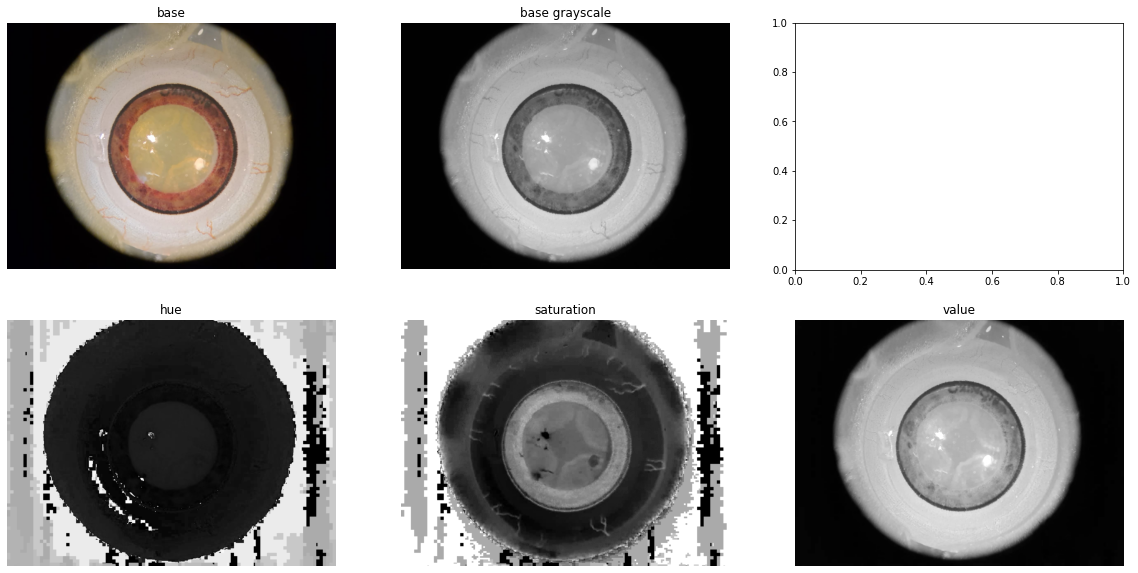

In [31]:
base = cv2.imread('data/artificial/base1.jpeg', cv2.IMREAD_COLOR)
base_rgb = cv2.cvtColor(base, cv2.COLOR_BGR2RGB)
base_gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)

base_hue = base_hsv[:, :, 0]
base_saturation = base_hsv[:, :, 1]
base_value = base_hsv[:, :, 2]

fig, ((plot1, plot2, _), (plot3, plot4, plot5)
      ) = plt.subplots(2, 3, figsize=(20, 10))
plot1.set_title('base')
plot1.imshow(base_rgb)
plot1.axis('off')

plot2.set_title('base grayscale')
plot2.imshow(base_gray, cmap=plt.cm.gray)
plot2.axis('off')

plot3.set_title('hue')
plot3.imshow(base_hue, cmap=plt.cm.gray)
plot3.axis('off')

plot4.set_title('saturation')
plot4.imshow(base_saturation, cmap=plt.cm.gray)
plot4.axis('off')

plot5.set_title('value')
plot5.imshow(base_value, cmap=plt.cm.gray)
plot5.axis('off')

plt.show()

In [32]:
scale = 0.4
base_gray_small = cv2.resize(base_gray, (0, 0), fx=scale, fy=scale)
base_gray_small.shape

(480, 640)

### 2. Helper functions

In [33]:
def get_tuple_point(array_point):
    return tuple(np.round(array_point).astype('int'))

In [34]:
def detect_circle(gray, return_all=False):
    circles = cv2.HoughCircles(
        cv2.GaussianBlur(255 - gray, ksize=(0, 0), sigmaX=2),
        cv2.HOUGH_GRADIENT, dp=1, minDist=10,
        param1=120, param2=40,
        minRadius=gray.shape[0]//10, maxRadius=round(gray.shape[0]//1.5)
    )

    if circles is None:
        return None

    if return_all:
        return circles[0, :, :]

    return circles[0, 0, :2], circles[0, 0, 2]

In [35]:
def get_avg_laplacian(laplacian, center, radius):
    mask = np.zeros(laplacian.shape, dtype=np.byte)
    cv2.circle(mask, center, radius, 1)
    return np.mean(np.abs(laplacian[mask == 1]))

### 3. Laplacian based circle validation

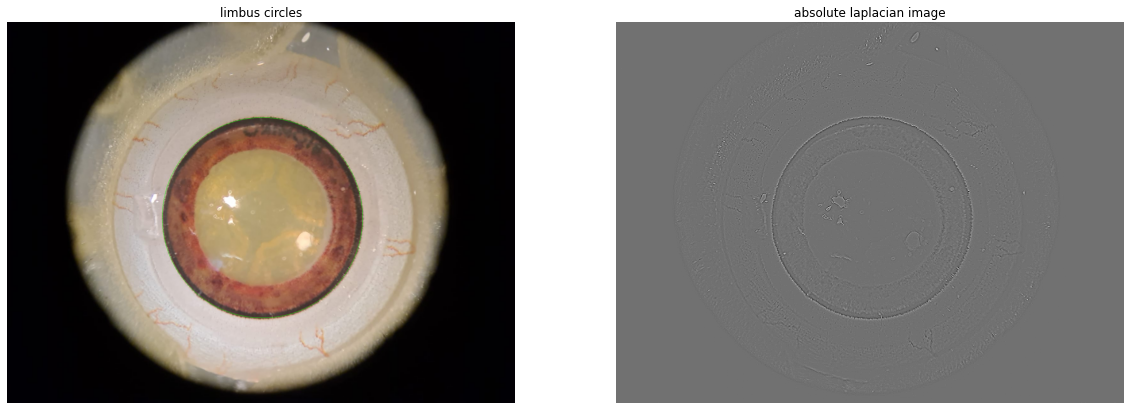

In [36]:
circles = detect_circle(base_gray_small, return_all=True)

base_copy = base_rgb.copy()
for circle in circles[:1, :]:
    limbus_center = circle[:2] / scale
    limbus_radius = circle[2] / scale

#     cv2.drawMarker(base_copy, get_tuple_point(limbus_center), (0,255,0))
    cv2.circle(base_copy, get_tuple_point(limbus_center),
               round(limbus_radius), (0, 255, 0), thickness=1)

fig, plots = plt.subplots(1, 2, figsize=(20, 10))
plots[0].set_title('limbus circles')
plots[0].imshow(base_copy)
plots[0].axis('off')

plots[1].set_title('absolute laplacian image')
# plots[1].imshow(np.abs(cv2.Laplacian(base_gray_small, cv2.CV_16S)), cmap=plt.cm.gray)
plots[1].imshow(cv2.Laplacian(255 - base_gray_small,
                cv2.CV_16S), cmap=plt.cm.gray)
plots[1].axis('off')

plt.show()

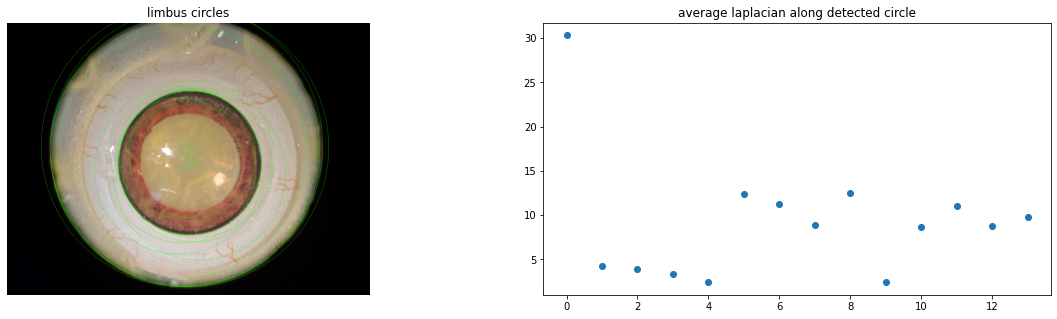

In [37]:
circles = detect_circle(base_gray_small, return_all=True)
base_laplacian = cv2.Laplacian(base_gray_small, cv2.CV_16S)

avg_laplacians = np.zeros(circles.shape[0])
base_copy = base_rgb.copy()
for index, circle in enumerate(circles):
    limbus_center = get_tuple_point(circle[:2])
    limbus_radius = np.round(circle[2]).astype('int')
    avg_laplacians[index] = get_avg_laplacian(
        base_laplacian, limbus_center, limbus_radius)

    limbus_center = get_tuple_point(circle[:2] / scale)
    limbus_radius = np.round(circle[2] / scale).astype('int')
    cv2.putText(base_copy, str(index), limbus_center,
                cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 1)
    cv2.circle(base_copy, limbus_center,
               limbus_radius, (0, 255, 0), thickness=1)

fig, plots = plt.subplots(1, 2, figsize=(20, 5))
plots[0].set_title('limbus circles')
plots[0].imshow(base_copy)
plots[0].axis('off')

plots[1].set_title('average laplacian along detected circle')
plots[1].scatter(range(avg_laplacians.shape[0]), avg_laplacians)

plt.show()

### 4. Custom Hough circle transform for visualization purposes
Takes a considerable time to compute (~minutes).

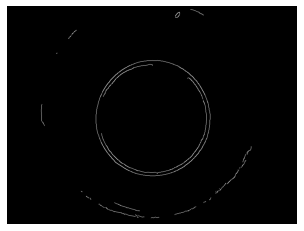

In [38]:
canny = cv2.Canny(cv2.GaussianBlur(255 - cv2.resize(base_value,
                  (0, 0), fx=0.5, fy=0.5), ksize=(0, 0), sigmaX=2), 120, 60)

plt.imshow(canny, cmap='gray')
plt.axis('off')
plt.show()

In [39]:
scale = 0.125
hough = np.zeros((int(canny.shape[0]*scale), int(canny.shape[1]
                 * scale), int(max(canny.shape[0], canny.shape[1])*scale)))

for y in range(canny.shape[0]):
    for x in range(canny.shape[1]):
        if canny[y, x] == 0:
            continue

        y_s = int(y*scale)
        x_s = int(x*scale)
        for y_0 in range(hough.shape[0]):
            for x_0 in range(hough.shape[1]):
                r = int(np.sqrt((x_s - x_0)**2 + (y_s - y_0)**2))
                if r < hough.shape[2]:
                    hough[y_0, x_0, r] += 1

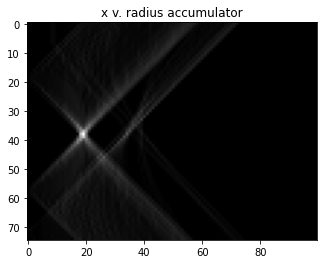

In [40]:
plt.title('x v. radius accumulator')
plt.imshow(hough[:, 50, :], cmap='gray')
plt.show()

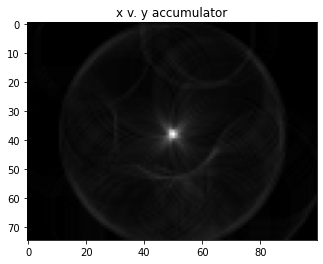

In [41]:
plt.title('x v. y accumulator')
plt.imshow(hough[:, :, 19], cmap='gray')
plt.show()

### 5. Normalizing and saving the results (optional)

In [ ]:
hough_x_fixed = hough[:, 50, :].copy()
hough_x_fixed *= 255/np.max(hough_x_fixed)
hough_r_fixed = hough[:, :, 19].copy()
hough_r_fixed *= 255/np.max(hough_r_fixed)

cv2.imwrite('canny_p.png', canny)
cv2.imwrite('base_value_p.png', base_value)
cv2.imwrite('hough_x_fixed_p.png', hough_x_fixed)
cv2.imwrite('hough_r_fixed_p.png', hough_r_fixed)